In [1]:
import pandas as pd
import json
import pprint
import re
import csv

%matplotlib inline
import matplotlib
matplotlib.style.use('ggplot')

import seaborn as sns
sns.set_style("whitegrid")

printer = pprint.PrettyPrinter(indent=4)
pp = printer.pprint

In [2]:
#Load the data

data_path = './data/cards.collectible.json'
all_cards = json.loads(open(data_path).read())
all_cards_df = pd.DataFrame(all_cards)
pp(all_cards[200])

{   'artist': 'Raven Mimura',
    'collectible': True,
    'cost': 3,
    'dbfId': 40393,
    'dust': [100, 800, 20, 100],
    'flavor': 'You know what really makes my blood boil? The skyrocketing '
              'price of Bloodfury potions!',
    'id': 'CFM_611',
    'name': 'Bloodfury Potion',
    'playRequirements': {'REQ_MINION_TARGET': 0, 'REQ_TARGET_TO_PLAY': 0},
    'playerClass': 'WARLOCK',
    'rarity': 'RARE',
    'set': 'GANGS',
    'text': '[x]Give a minion +3 Attack.\n'
            "If it's a Demon, also\n"
            'give it +3 Health.',
    'type': 'SPELL'}


In [3]:
# load 2nd data source with image names and join to the first
data_path_2 = './hearthstone-db/cards/all-collectibles.json'
cards_with_img = json.loads(open(data_path_2).read())['cards']
cards_with_img_df = pd.DataFrame(cards_with_img)[['name', 'id', 'image_url']]

cards_with_img_df.columns = ['name', 'image_name', 'image_url']
cards_with_img_df['image_name'] = cards_with_img_df['image_name'].apply(lambda x: str(x) + '.png')

all_cards_df = all_cards_df.merge(cards_with_img_df, on='name')

In [4]:
# Filter down to just neutral minions
all_neutral_minions = all_cards_df[(all_cards_df.playerClass == 'NEUTRAL') & (all_cards_df.type == 'MINION')]

In [5]:
len(all_neutral_minions[all_neutral_minions.cost == 4])

70

In [6]:
# Define Our Helper functions

# This function will calculate the efficiency/trade score for all minions
# of a given set of cards at a target mana.
def score_minions(cards, target_mana, score_func):
    TARGET_MANA = target_mana
    
    neutral_minions = cards[(cards.playerClass == 'NEUTRAL') & (cards.type == 'MINION')]
    spells = get_spells_with_damage(cards, target_mana)

    target = neutral_minions[all_neutral_minions.cost == TARGET_MANA]
    up = neutral_minions[all_neutral_minions.cost == (TARGET_MANA + 1)]
    down = neutral_minions[all_neutral_minions.cost == (TARGET_MANA + -1)]    
    
    if score_func == trade_value_relative:
        # an alternative model where we take all minions with lower costs into account
        print("trade_value_relative")
        down = neutral_minions[all_neutral_minions.cost < TARGET_MANA]
    
    trade_scores = []

    for i, minion in target.iterrows():
        minion_score = 0
        #'Equal mana drops'
        for j, other_minion in target.iterrows():
            tscore = score_func(minion, other_minion)
            minion_score += tscore

        #'Lower mana drops';
        for j, other_minion in down.iterrows():
            tscore = score_func(minion, other_minion)
            minion_score += tscore

        #'Higher mana drops';
        for j, other_minion in up.iterrows():
            tscore = score_func(minion, other_minion)
            minion_score += tscore

        # Spells
        for j, spell in spells.iterrows():
            tscore = score_func(minion, spell)
            minion_score += tscore

        trade_scores.append(minion_score)

    scores_df = pd.DataFrame({'trade_score': trade_scores})
    scores_df.index = target.index
    
    scored = target.copy()
    scored['trade_score'] = scores_df['trade_score']
    scored = scored.sort_values('trade_score', ascending=False)
    return scored


# This function will calculate the efficiency/trade score for one minion against
# another minion
def minion_trade(minion, other_minion, relative=False):
    m = minion
    o = other_minion
    
    WIN = m['attack'] >= o['health'] and o['attack'] < m['health']
    TRADE = m['attack'] >= o['health'] and o['attack'] >= m['health']
    LOSE = m['attack'] < o['health'] and o['attack'] >= m['health']
    
    
    # Even Mana cost
    EVEN = m['cost'] == o['cost']
    
    # Other minion is higher mana cost
    UP = o['cost'] > m['cost']
    
    # Other minion is lower mana cost
    DOWN = o['cost'] < m['cost']
    
    
    # Calculate a score for minion m.

    score = 0
    
    if WIN and EVEN:
        score += 2
    elif WIN and UP:
        score += 2.5
    elif WIN and DOWN:
        score += 1.5

    elif TRADE and EVEN:
        score += 1
    elif TRADE and UP:
        score += 1.5
    elif TRADE and DOWN:
        if relative:
            score += o['cost'] - m['cost']
        else:
            score += -0.5

    elif LOSE and EVEN:
        score += -1
    elif LOSE and UP:
        score += 0
    elif LOSE and DOWN:
        if relative:
            score += o['cost'] - m['cost']
        else:
            score += -2.5

    
#     if m['name'] == 'Twilight Drake' or m['name'] == 'Faceless Shambler':
#         if o['name'] == 'Fjola Lightbane':
#             print(m['name'], 'vs', o['name'], score, 'WIN', WIN, 'UP', UP)
    
    return score


def trade_value(minion, other_minion):
    if other_minion['type'] == 'SPELL':
        return 0
    else:
        return minion_trade(minion, other_minion)

    

# Helper function to return spells that do damage to minions
def get_spells_with_damage(cards, target_mana):
    spells = cards[(cards.type == 'SPELL')]
    target_spells = spells[spells.cost <= target_mana]
    target_spells = target_spells.copy()
    
    # We need to augment the data with the damage dealt by a spell.
    # There are spells that completely destroy arbitrary minions, assasinate, siphon
    # soul, etc. But since they damage pretty much everything equally we can pretty
    # much ignore them (unless we also choose to model untargeteable minions)
    deals_damage = re.compile('Deal \$?(\d+).*damage')
    enemy_hero = re.compile('.*enemy hero.*')

    def get_damage(row):
        text = row.text
        m = deals_damage.match(text)
        e = enemy_hero.match(text) 
        if m and not e:
            return int(m.group(1))
        else:
            return None
    
    target_spells['damage'] = target_spells.apply(lambda row: get_damage(row),axis=1)
    
    damage_spells = target_spells[target_spells['damage'] > 0]
    damage_spells = damage_spells.copy()
    
    # Manually update 'eviscerate' and assume higher damage/combo
    damage_spells.set_value(index=674,col='damage', value=4)
    return damage_spells


# This function will calculate the efficiency/trade score for one minion against
# another minion or spell.
def trade_value_wspells(minion, other_minion, relative=False):
    m = minion
    o = other_minion
    
    if other_minion['type'] == 'SPELL':
        if o['damage'] > m['health'] and o['cost'] < m['cost']:
            # We only penalize the minion if it died to a lower cost spell
            return o['cost'] - m['cost']
        else:
            return 0
    else:
        return minion_trade(minion, other_minion, relative)
    

# This function will calculate the efficiency/trade score for one minion against
# another minion or spell, but also take into account the difference in cost 
# when trading (or losing) down
def trade_value_relative(minion, other_minion):
    return trade_value_wspells(minion, other_minion, relative=True)

# This will return a dataframe of cards with just a few columns selected
# useful for display
def summary_df(cards, target_mana=None):
    cols = ['name', 'cost', 'attack', 'health', 'trade_score', 'text', 'set', 'image_name', 'image_url']
    if target_mana == None:
        return cards[cols]
    else:
        return cards[cards['cost'] == target_mana][cols]
    
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

In [7]:
# Lets define some card sets

# Core - Basic and Free
core_cards = all_cards_df[(all_cards_df.set == 'CORE')]
# Basic (incluing basic non free)
basic_cards = all_cards_df[(all_cards_df.set == 'CORE') | (all_cards_df.set == 'EXPERT1')]
# Wild 
wild_cards = all_cards_df
# Standard (Jan 2017 — Year of the Kraken)
standard_cards = all_cards_df[(all_cards_df.set == 'CORE') \
        | (all_cards_df.set == 'EXPERT1') \
        | (all_cards_df.set == 'BRM')  \
        | (all_cards_df.set == 'TGT') \
        | (all_cards_df.set == 'LOE') \
        | (all_cards_df.set == 'OG') \
        | (all_cards_df.set == 'KARA') \
        | (all_cards_df.set == 'GANGS') \
    ]

In [8]:
# Lets look at the four drops from standard

scored_minions_fd = pd.DataFrame()
target_set = standard_cards
score_func = trade_value
for cost in range(4, 5):
    res = score_minions(target_set, cost, score_func)
    scored_minions_fd = scored_minions_fd.append(res)

/Users/yannick/anaconda/envs/jupyter/lib/python3.5/site-packages/pandas/core/frame.py:1997: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


In [9]:
summary_df(scored_minions_fd, 4)

,name,cost,attack,health,trade_score,text,set,image_name,image_url
59,Eerie Statue,4,7,7,338.0,Can’t attack unless it’s the only minion in th...,LOE,4012.png,http://wow.zamimg.com/images/hearthstone/cards...
987,Hungry Dragon,4,5,6,276.5,<b>Battlecry:</b> Summon a random 1-Cost minio...,BRM,2323.png,http://wow.zamimg.com/images/hearthstone/cards...
878,Ancient Shade,4,7,4,261.0,<b>Battlecry:</b> Shuffle an 'Ancient Curse' i...,LOE,4007.png,http://wow.zamimg.com/images/hearthstone/cards...
1031,Evil Heckler,4,5,4,208.0,<b>Taunt</b>,TGT,3113.png,http://wow.zamimg.com/images/hearthstone/cards...
1027,"Genzo, the Shark",4,5,4,208.0,"Whenever this attacks, both players draw until...",GANGS,7070.png,http://media.services.zam.com/v1/media/byName/...
991,Ancient Brewmaster,4,5,4,208.0,<b>Battlecry:</b> Return a friendly minion fro...,EXPERT1,186.png,http://wow.zamimg.com/images/hearthstone/cards...
131,Naga Corsair,4,5,4,208.0,<b>Battlecry:</b> Give your weapon +1 Attack.,GANGS,7081.png,http://media.services.zam.com/v1/media/byName/...
688,Chillwind Yeti,4,4,5,208.0,NaN,CORE,90.png,http://wow.zamimg.com/images/hearthstone/cards...
572,Worgen Greaser,4,6,3,177.5,NaN,GANGS,7085.png,http://media.services.zam.com/v1/media/byName/...
13,Crowd Favorite,4,4,4,164.5,Whenever you play a card with <b>Battlecry</b>...,TGT,3120.png,http://wow.zamimg.com/images/hearthstone/cards...


In [10]:
# Now do the same but take spells into account

scored_minions_fd = pd.DataFrame()
target_set = standard_cards
score_func = trade_value_wspells
for cost in range(4, 5):
    res = score_minions(target_set, cost, score_func)
    scored_minions_fd = scored_minions_fd.append(res)

/Users/yannick/anaconda/envs/jupyter/lib/python3.5/site-packages/pandas/core/frame.py:1997: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


In [11]:
summary_df(scored_minions_fd, 4)

,name,cost,attack,health,trade_score,text,set,image_name,image_url
59,Eerie Statue,4,7,7,337.0,Can’t attack unless it’s the only minion in th...,LOE,4012.png,http://wow.zamimg.com/images/hearthstone/cards...
987,Hungry Dragon,4,5,6,275.5,<b>Battlecry:</b> Summon a random 1-Cost minio...,BRM,2323.png,http://wow.zamimg.com/images/hearthstone/cards...
878,Ancient Shade,4,7,4,258.0,<b>Battlecry:</b> Shuffle an 'Ancient Curse' i...,LOE,4007.png,http://wow.zamimg.com/images/hearthstone/cards...
688,Chillwind Yeti,4,4,5,207.0,NaN,CORE,90.png,http://wow.zamimg.com/images/hearthstone/cards...
1031,Evil Heckler,4,5,4,205.0,<b>Taunt</b>,TGT,3113.png,http://wow.zamimg.com/images/hearthstone/cards...
1027,"Genzo, the Shark",4,5,4,205.0,"Whenever this attacks, both players draw until...",GANGS,7070.png,http://media.services.zam.com/v1/media/byName/...
991,Ancient Brewmaster,4,5,4,205.0,<b>Battlecry:</b> Return a friendly minion fro...,EXPERT1,186.png,http://wow.zamimg.com/images/hearthstone/cards...
131,Naga Corsair,4,5,4,205.0,<b>Battlecry:</b> Give your weapon +1 Attack.,GANGS,7081.png,http://media.services.zam.com/v1/media/byName/...
572,Worgen Greaser,4,6,3,170.5,NaN,GANGS,7085.png,http://media.services.zam.com/v1/media/byName/...
13,Crowd Favorite,4,4,4,161.5,Whenever you play a card with <b>Battlecry</b>...,TGT,3120.png,http://wow.zamimg.com/images/hearthstone/cards...


In [12]:
# Lets do it for all mana costs and sets

score_func = trade_value_wspells

# Core cards
scored_minions_core = pd.DataFrame()
target_set = core_cards
for cost in range(10):
    res = score_minions(target_set, cost, score_func)
    scored_minions_core = scored_minions_core.append(res)
    
# Basic Cards
scored_minions_basic = pd.DataFrame()
target_set = basic_cards
for cost in range(11):
    res = score_minions(target_set, cost, score_func)
    scored_minions_basic = scored_minions_basic.append(res)    

# Standard Cards (Jan 2017)
scored_minions_standard = pd.DataFrame()
target_set = standard_cards
for cost in range(11):
    res = score_minions(target_set, cost, score_func)
    scored_minions_standard = scored_minions_standard.append(res)    

    
# All Cards (Wild)
# 
# scored_minions_wild = pd.DataFrame()
# target_set = wild_cards
# for cost in range(11):
#     res = score_minions(target_set, cost, score_func)
#     scored_minions_wild = scored_minions_wild.append(res)  

/Users/yannick/anaconda/envs/jupyter/lib/python3.5/site-packages/pandas/core/frame.py:1997: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


In [13]:
summary_df(scored_minions_standard, 4)

,name,cost,attack,health,trade_score,text,set,image_name,image_url
59,Eerie Statue,4,7,7,337.0,Can’t attack unless it’s the only minion in th...,LOE,4012.png,http://wow.zamimg.com/images/hearthstone/cards...
987,Hungry Dragon,4,5,6,275.5,<b>Battlecry:</b> Summon a random 1-Cost minio...,BRM,2323.png,http://wow.zamimg.com/images/hearthstone/cards...
878,Ancient Shade,4,7,4,258.0,<b>Battlecry:</b> Shuffle an 'Ancient Curse' i...,LOE,4007.png,http://wow.zamimg.com/images/hearthstone/cards...
688,Chillwind Yeti,4,4,5,207.0,NaN,CORE,90.png,http://wow.zamimg.com/images/hearthstone/cards...
1031,Evil Heckler,4,5,4,205.0,<b>Taunt</b>,TGT,3113.png,http://wow.zamimg.com/images/hearthstone/cards...
1027,"Genzo, the Shark",4,5,4,205.0,"Whenever this attacks, both players draw until...",GANGS,7070.png,http://media.services.zam.com/v1/media/byName/...
991,Ancient Brewmaster,4,5,4,205.0,<b>Battlecry:</b> Return a friendly minion fro...,EXPERT1,186.png,http://wow.zamimg.com/images/hearthstone/cards...
131,Naga Corsair,4,5,4,205.0,<b>Battlecry:</b> Give your weapon +1 Attack.,GANGS,7081.png,http://media.services.zam.com/v1/media/byName/...
572,Worgen Greaser,4,6,3,170.5,NaN,GANGS,7085.png,http://media.services.zam.com/v1/media/byName/...
13,Crowd Favorite,4,4,4,161.5,Whenever you play a card with <b>Battlecry</b>...,TGT,3120.png,http://wow.zamimg.com/images/hearthstone/cards...


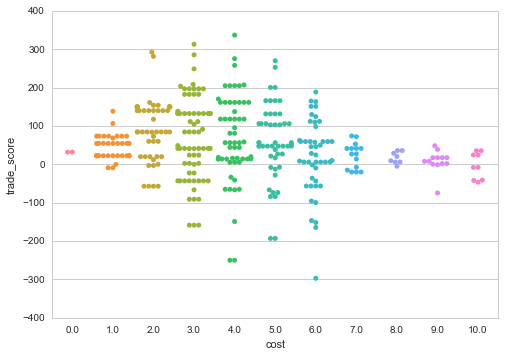

In [14]:
sns.swarmplot(x="cost", y="trade_score", data=scored_minions_standard)

In [15]:
# We could also use a different model where the difference in mana cost
# has a greater penalty when trading down (e.g. a 4 mana cost losing to 
# a 2 mana cost would be penalized more than a 4 mana cost losing to a 3 mana
# card)

scored_minions_relative = pd.DataFrame()
target_set = standard_cards
score_func = trade_value_relative
for cost in range(10):
    res = score_minions(target_set, cost, score_func)
    scored_minions_relative = scored_minions_relative.append(res)

trade_value_relative
trade_value_relative
trade_value_relative
trade_value_relative
trade_value_relative
trade_value_relative
trade_value_relative
trade_value_relative
trade_value_relative
trade_value_relative


/Users/yannick/anaconda/envs/jupyter/lib/python3.5/site-packages/pandas/core/frame.py:1997: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


In [16]:
summary_df(scored_minions_relative, 4)

,name,cost,attack,health,trade_score,text,set,image_name,image_url
59,Eerie Statue,4,7,7,466.0,Can’t attack unless it’s the only minion in th...,LOE,4012.png,http://wow.zamimg.com/images/hearthstone/cards...
987,Hungry Dragon,4,5,6,401.5,<b>Battlecry:</b> Summon a random 1-Cost minio...,BRM,2323.png,http://wow.zamimg.com/images/hearthstone/cards...
878,Ancient Shade,4,7,4,370.5,<b>Battlecry:</b> Shuffle an 'Ancient Curse' i...,LOE,4007.png,http://wow.zamimg.com/images/hearthstone/cards...
688,Chillwind Yeti,4,4,5,332.0,NaN,CORE,90.png,http://wow.zamimg.com/images/hearthstone/cards...
1031,Evil Heckler,4,5,4,316.5,<b>Taunt</b>,TGT,3113.png,http://wow.zamimg.com/images/hearthstone/cards...
1027,"Genzo, the Shark",4,5,4,316.5,"Whenever this attacks, both players draw until...",GANGS,7070.png,http://media.services.zam.com/v1/media/byName/...
991,Ancient Brewmaster,4,5,4,316.5,<b>Battlecry:</b> Return a friendly minion fro...,EXPERT1,186.png,http://wow.zamimg.com/images/hearthstone/cards...
131,Naga Corsair,4,5,4,316.5,<b>Battlecry:</b> Give your weapon +1 Attack.,GANGS,7081.png,http://media.services.zam.com/v1/media/byName/...
13,Crowd Favorite,4,4,4,275.0,Whenever you play a card with <b>Battlecry</b>...,TGT,3120.png,http://wow.zamimg.com/images/hearthstone/cards...
376,Ogre Magi,4,4,4,275.0,<b>Spell Damage +1</b>,CORE,995.png,http://wow.zamimg.com/images/hearthstone/cards...


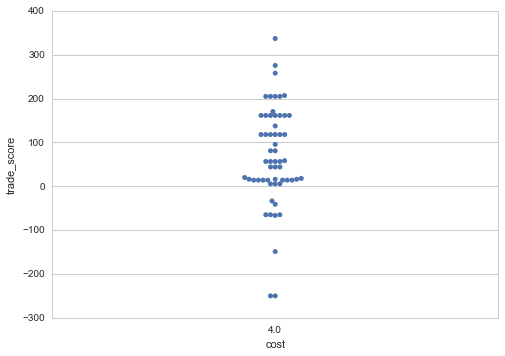

In [17]:
sns.swarmplot(x="cost", y="trade_score", data=scored_minions_fd)

In [18]:
# Output the results to a file

fp = './results/standard_all_updown.csv'
summary_df(scored_minions_standard).to_csv(fp, quoting=csv.QUOTE_NONNUMERIC, index_label='index')

# for cost in range(11):
#     fp = './results/standard_' + str(cost) + '_updown.csv'
#     summary_df(scored_minions_standard, cost).to_csv(fp, quoting=csv.QUOTE_NONNUMERIC, index_label='index')

In [19]:
# Output the results to a file

fp = './results/standard_all_relative.csv'
summary_df(scored_minions_relative).to_csv(fp, quoting=csv.QUOTE_NONNUMERIC, index_label='index')

# for cost in range(11):
#     fp = './results/standard_' + str(cost) + '_relative.csv'
#     summary_df(scored_minions_relative, cost).to_csv(fp, quoting=csv.QUOTE_NONNUMERIC, index_label='index')